**Импортируем необходимые библиотеки**

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

**Первичный анализ данных и заполнение пропусков**

In [125]:
df = pd.read_csv('Physical_Activity_Monitoring_unlabeled.csv')

print(f"Размер датасета: {df.shape}")
display(df.head())
print("\nMissed:")
print(df.isnull().sum())

Размер датасета: (534601, 53)


,timestamp,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,252.75,34.8750,0.902847,7.45872,6.032490,1.006100,7.44575,6.303650,-0.021952,0.004114,...,-0.025606,0.030239,-14.5447,27.3336,-5.76620,0.206416,0.348212,0.763201,-0.503652,5
1,3652.45,29.7500,-4.069330,3.76168,8.279720,-5.972500,3.22273,6.908970,0.116054,-0.375968,...,-0.670163,1.786200,-32.8257,-15.7719,-1.31395,0.578332,-0.566734,0.405888,-0.423791,2
2,504.76,34.3750,-2.007540,-9.60180,0.773674,-1.803500,-9.58937,1.073680,0.020131,0.042189,...,-0.009741,-0.006579,-18.8171,16.3089,25.29280,0.139776,0.676586,0.393796,0.606316,8
3,2801.61,31.9375,-13.262200,5.85443,0.899334,-13.611500,5.91511,0.840377,1.715630,-0.050492,...,-0.163470,-3.495570,-26.7418,34.3566,21.32740,0.416303,0.783387,0.306464,0.345075,2
4,441.01,33.5000,-0.013940,8.66540,4.398210,0.144153,8.56816,4.822200,-0.006938,-0.007383,...,-0.028172,-0.003737,-17.7798,-3.9981,10.99500,0.171133,-0.748343,0.252988,-0.588807,6



Missed:
timestamp               0
handTemperature      4041
handAcc16_1          4041
handAcc16_2          4041
handAcc16_3          4041
handAcc6_1           4041
handAcc6_2           4041
handAcc6_3           4041
handGyro1            4041
handGyro2            4041
handGyro3            4041
handMagne1           4041
handMagne2           4041
handMagne3           4041
handOrientation1     4041
handOrientation2     4041
handOrientation3     4041
handOrientation4     4041
chestTemperature      809
chestAcc16_1          809
chestAcc16_2          809
chestAcc16_3          809
chestAcc6_1           809
chestAcc6_2           809
chestAcc6_3           809
chestGyro1            809
chestGyro2            809
chestGyro3            809
chestMagne1           809
chestMagne2           809
chestMagne3           809
chestOrientation1     809
chestOrientation2     809
chestOrientation3     809
chestOrientation4     809
ankleTemperature     2546
ankleAcc16_1         2546
ankleAcc16_2         2546
ank

In [126]:
cols_with_nan = df.columns[df.isna().any()].tolist()
for col in cols_with_nan:
    df[col] = (
        df.groupby('subject_id')[col]
          .transform(lambda x: x.fillna(x.median()))
    )

print("\nMissed:")
print(df.isnull().sum())


Missed:
timestamp            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3          0
ankleGyro1           0
an

Если между признаками коэффицент корреляции больше 0.69, удалим их во избежание мультколлинеарности

In [127]:
corr_features = df
corr_matrix = corr_features.corr()
threshold = 0.69
to_drop = set()

for i, col1 in enumerate(corr_features.columns):
    for j, col2 in enumerate(corr_features.columns):
        if i < j and abs(corr_matrix.iloc[i, j]) > threshold:
            to_drop.add(col2)

df_cleared = corr_features.drop(columns=to_drop)
print(f"Удалено {len(to_drop)} признаков.")

Удалено 12 признаков.


**MinMaxScaler нужен, чтобы привести все признаки в один диапазон от 0 до 1.**

In [128]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_cleared), columns=df_cleared.columns)

**Через сэмплирование проведем быструю предварительную оценку**

In [129]:
segments = []
for subj_id, group in df_cleared.groupby("subject_id"):
    sampled = group.sample(frac=0.1, random_state=42)
    segments.append(sampled)

df_subsampled = shuffle(pd.concat(segments, ignore_index=True), random_state=42)

**Метод локтя**

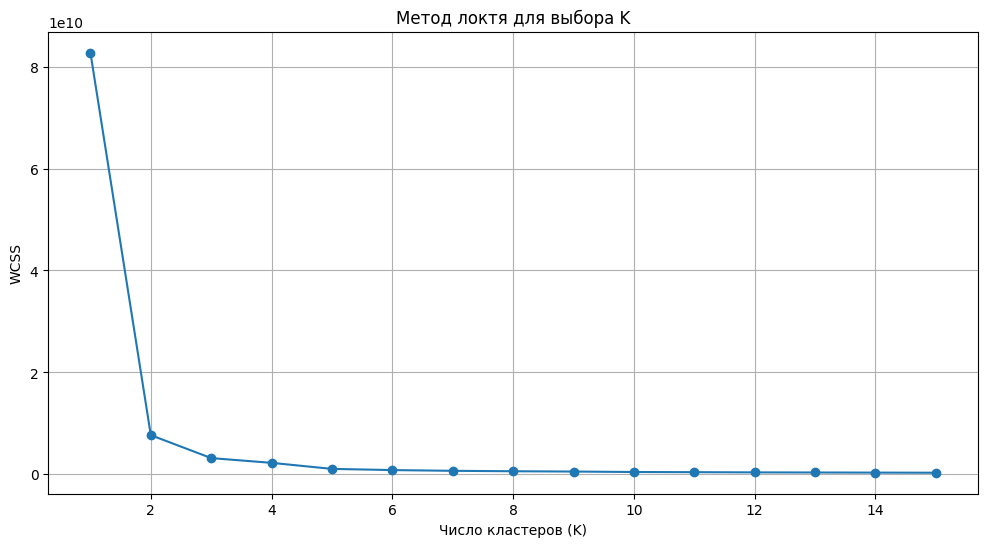

In [130]:
wcss = []
k_values = range(1, 16)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_subsampled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_values, wcss, marker='o', linestyle='-')
plt.xlabel("Число кластеров (K)")
plt.ylabel("WCSS")
plt.title("Метод локтя для выбора K")
plt.grid(True)
plt.show()

Возьмем оптимальные значения из графика и посчитаем силуэт при 5, 6, 7 кластерах.

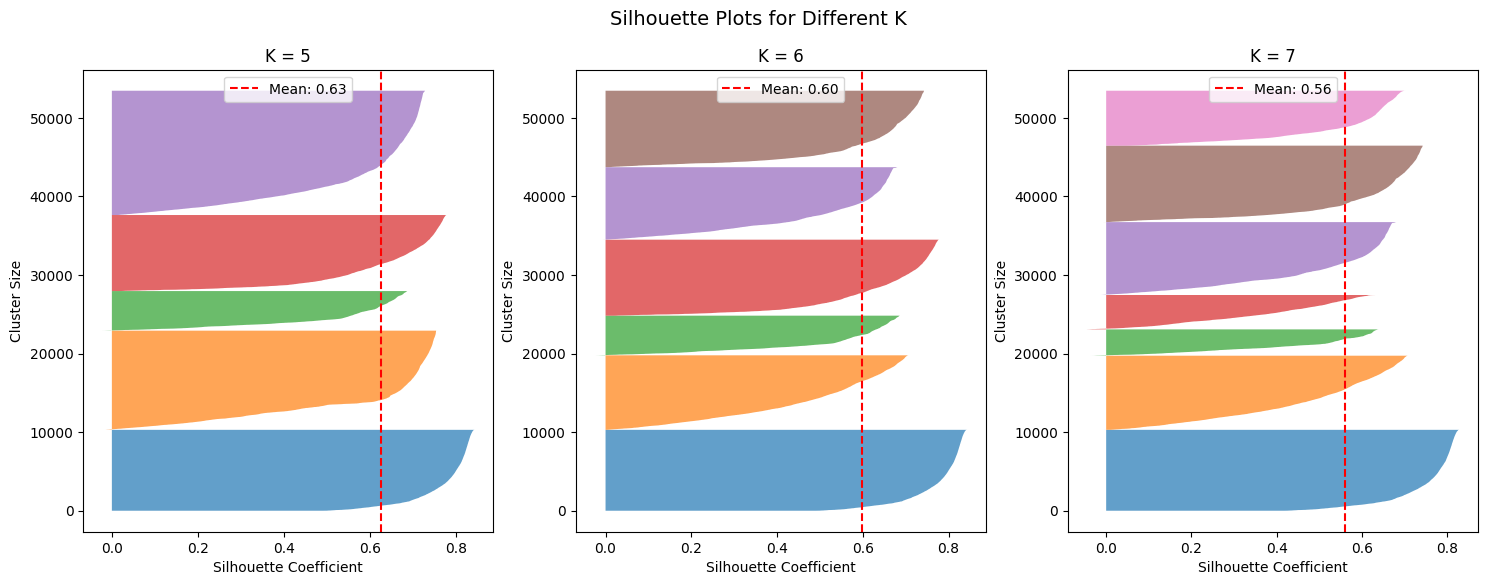

In [131]:
# Функция для построения силуэтных графиков
def plot_silhouette(X, cluster_counts):
    fig, axes = plt.subplots(1, len(cluster_counts), figsize=(18, 6))

    for idx, K in enumerate(cluster_counts):
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        # Вычисляем силуэтные коэффициенты
        silhouette_vals = silhouette_samples(X, cluster_labels)

        y_lower, y_upper = 0, 0
        axes[idx].set_title(f"K = {K}")
        
        for i in range(K):
            cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
            cluster_silhouette_vals.sort()

            y_upper += len(cluster_silhouette_vals)
            axes[idx].fill_betweenx(
                np.arange(y_lower, y_upper), 
                0, 
                cluster_silhouette_vals, 
                alpha=0.7
            )
            y_lower = y_upper
        
        avg_score = silhouette_score(X, cluster_labels)
        axes[idx].axvline(avg_score, linestyle="--", color="red", label=f"Mean: {avg_score:.2f}")
        axes[idx].legend()
        axes[idx].set_xlabel("Silhouette Coefficient")
        axes[idx].set_ylabel("Cluster Size")
    
    plt.suptitle("Silhouette Plots for Different K", fontsize=14)
    plt.show()

# Вызываем функцию для K=5, 6, 7
plot_silhouette(df_subsampled, cluster_counts=[5, 6, 7])

**Визуальная кластеризация**

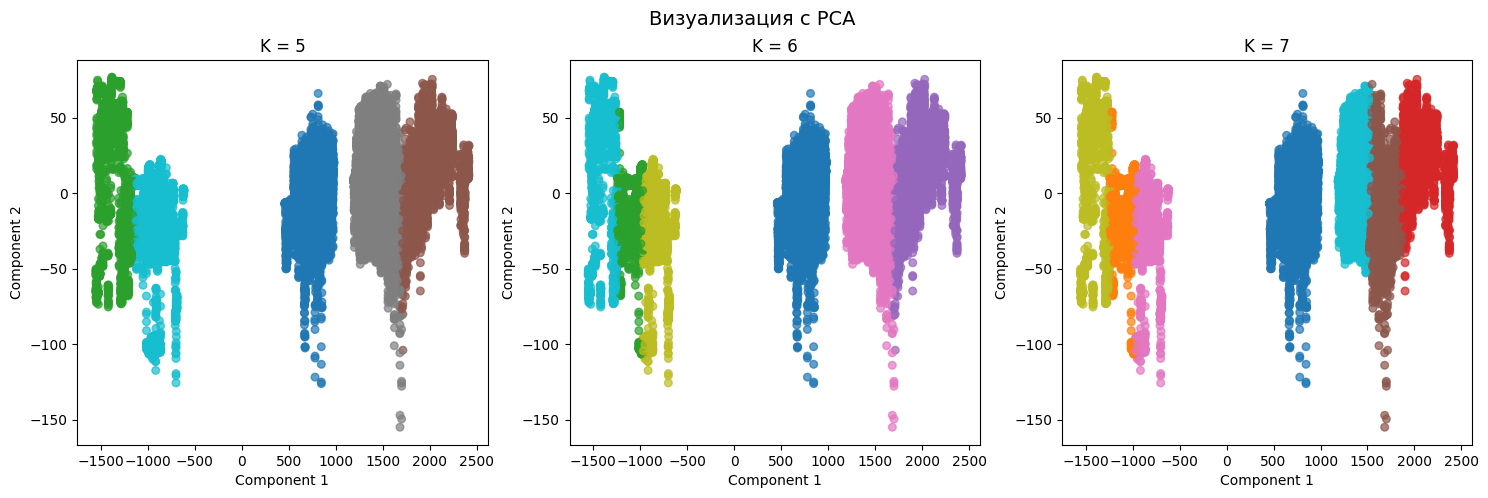

In [132]:
def plot_clusters_2d(X, cluster_counts):

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    fig, axes = plt.subplots(1, len(cluster_counts), figsize=(6 * len(cluster_counts), 5))

    for idx, K in enumerate(cluster_counts):
        kmeans = KMeans(n_clusters=K, random_state=42)
        cluster_labels = kmeans.fit_predict(X)

        axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', s=30, alpha=0.7)
        axes[idx].set_title(f"K = {K}")
        axes[idx].set_xlabel("Component 1")
        axes[idx].set_ylabel("Component 2")
    
    plt.suptitle("Визуализация с PCA", fontsize=14)
    plt.show()

plot_clusters_2d(df_subsampled, cluster_counts=[5, 6, 7])


Визуально выбор стоит между 5 и 6 кластерами, метрика силуэта лучше у эксперимента с 5 кластерами, но при K=6 график выглядит более сбалансированным. Пусть К = 6

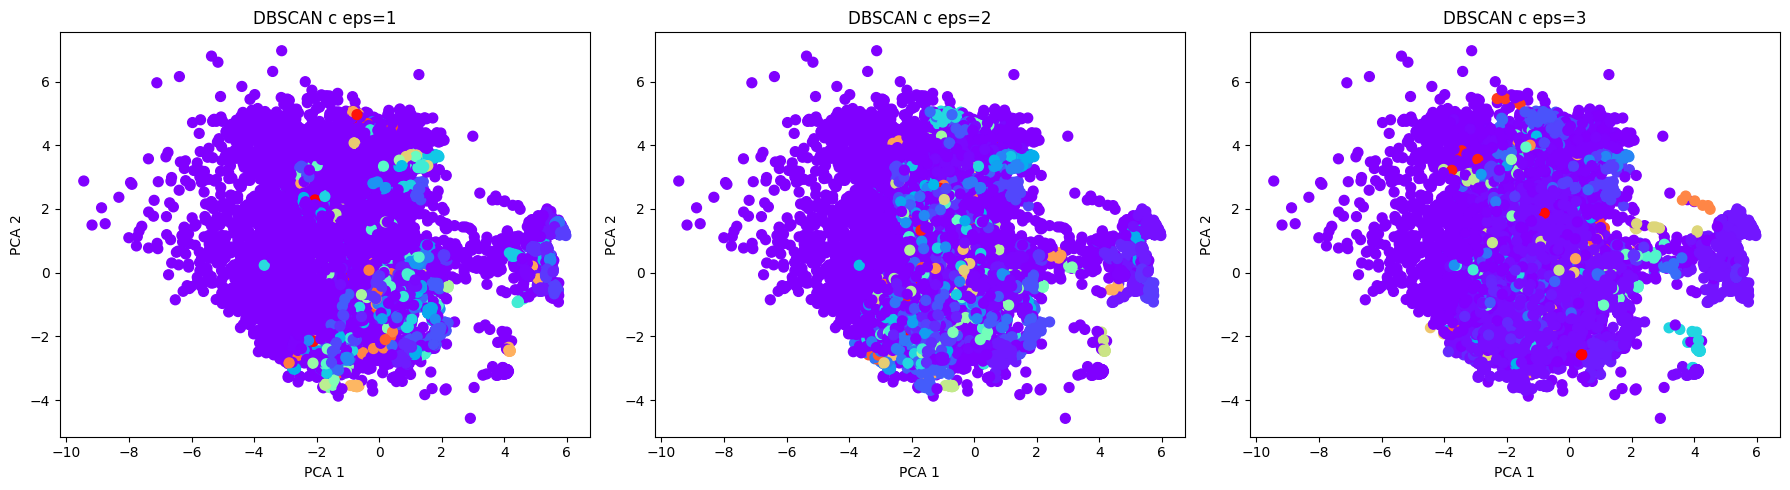

In [133]:
# Предобработка
X_scaled = StandardScaler().fit_transform(df_subsampled)

# Для визуализации понизим размерность до 2D
X_pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)

# Значения eps для тестирования
eps_values = [1, 2, 3]

# Создаем подграфики
fig, axes = plt.subplots(1, len(eps_values), figsize=(18, 5))

# Запускаем DBSCAN с разными eps
for i, e in enumerate(eps_values):
    dbscan = DBSCAN(eps=e, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    # Визуализация результатов
    axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="rainbow", s=50)
    axes[i].set_title(f"DBSCAN с eps={e}")
    axes[i].set_xlabel("PCA 1")
    axes[i].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


Метод не подходит: из графиков видно, что алгоритм отмечает большенство точек как шум.

Таким образом, результат будем считать при К=6:

In [134]:
clasters = 6
model = KMeans(n_clusters=clasters)

clusters = model.fit_predict(df_scaled)
df_scaled['cluster'] = clusters
df_scaled['activityID'] = -1
dict = {}
activityID = 1
for index, row in df_scaled.iterrows():
    if row['cluster'] in dict.keys():
        df_scaled.loc[index, 'activityID'] = dict[row['cluster']]
    else:
        dict[row['cluster']] = activityID
        df_scaled.loc[index, 'activityID'] = activityID
        activityID += 1


submission = df_scaled[['activityID']].reset_index()
submission.columns = ['Index', 'activityID']
submission.to_csv('submission.csv', index=False)

Результат на Kaggle - 0.45226

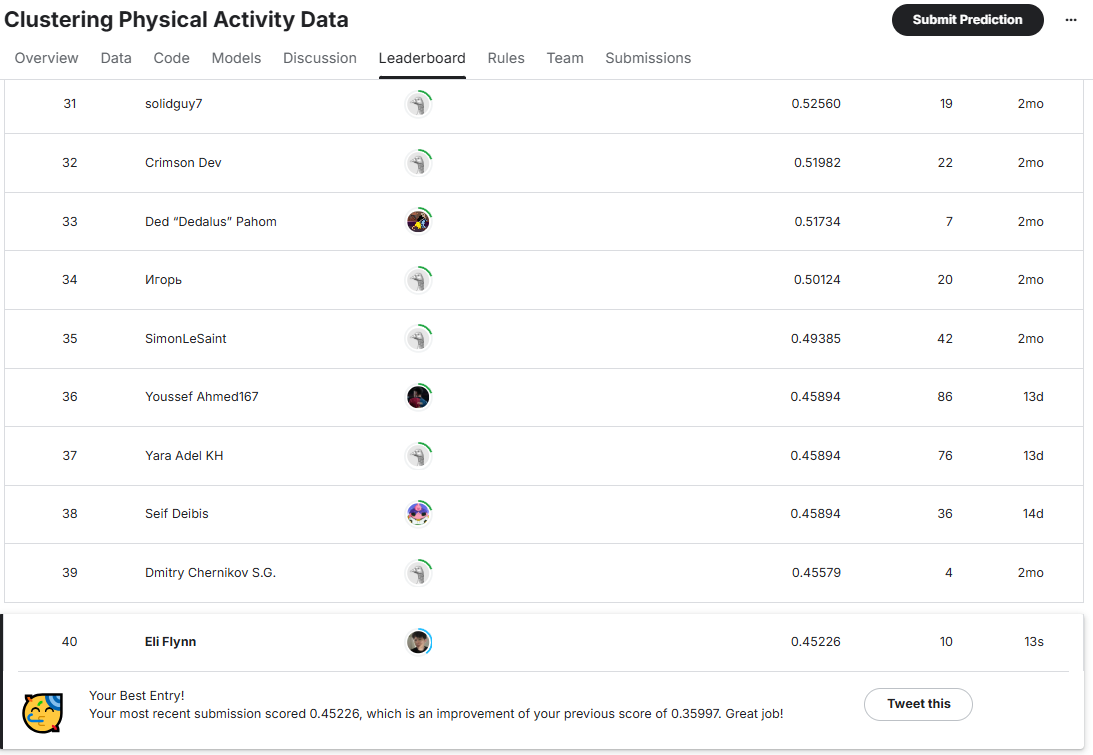